# Constructing an artificial neural network
> This notebook demonstrates implementing a neural network from scratch with Python without any libraries except Numpy. The choice for Python, rather than a fast low-level language like C, is made on the premise that this serves as learning material. The implementation is presented sequentially following the train of thought when building a neural network.  

- toc: true
- categories: [jupyter]
- badges: true
- image: images/nn.jpg



# Introducing the Neural Network 

Before going through this notebook, if you are a beginner, it can be useful to storm through this video by 3Blue1Brown, which will offer some visual intuition before you attack the text and code below:

> youtube: https://youtu.be/aircAruvnKk


The word neural in "neural network" comes from neurobiology from where the neural network architecture was loosely inspired, and the word 'network' is used because it encompasses multiple connected functions inside it resembling a network. In the process of explaining and constructing the neural network, we will be solving a supervised task. A supervised task is a task where there is a dataset of paired inputs and outputs:

$$\left\{\left(x_{i}, y_{i}\right)\right\}_{i=1}^{N}$$

With the use of neural networks, these paired inputs and outputs are assumed to have functional dependence which we don't know and are trying to approximate with it.
  
For example, later in this blog, we will try to teach/train a neural network to recognize does an image (input) represent a cat or not (output), therefore we assume that there is functional dependence between the pixels in the image and the output classes 'cat' and 'not-cat'.
  
What our neural network will then help us do is find that function or its close approximate. Therefore we come to an important conclusion:


> Important: Neural networks are function approximation machines.


A neural network is said to be able to approximate any function at all. More precisely, no matter what the function f is, there is guaranteed to be a neural network so that for every possible input x the neural network outputs f(x) or some close approximate.


>Tip: This theorem is called "The Universal Approximation Theorem"


The real challenge is finding such a network and specializing it for our task. 
  
Neural networks can approximate functions by being itself a chain of functions with adjustable parameters. 

$$y=f_{NN}(x)=f_{L}\left(\ldots f_{2}\left(f_{1}(x)\right)\right)$$

Individual functions in this equation are called layers, each representing a vector-to-vector operation. To better understand the neural network building blocks we can think of layers as consisting out of multiple simple vector-to-scalar computational units called neurons. These neurons are connected to each of the outputs of the preceding layer and calculate a weighted sum and apply an activation function on those inputs which produces an output.

![](my_icons/neuron.jpg "Representation of a single neuron in a Neural Network")

Where:
- $x_i$ is a real number called input
- $\omega_i$ is a real number called weight
- $\varphi$ is a function applied to the weighted sum called an activation function
- $b$ is a real number called bias
- $y$ is a real number called the output of a neuron

$\omega$ and $b$ are called the parameters of the neural network. 

Mathematical calculations of a whole layer of neurons can be represented with the following formula:

$$f_{l}(z)=\varphi_{l}\left(\mathbf{W}_{l} \mathbf{y}_{l-1}+\mathbf{b}_{l}\right)$$

Where:
- $\mathbf{W}_l$ is a matrix of weights for the current layer
- $\mathbf{y}_{l-1}$ is a vector of inputs to this layer
- $\mathbf{b}_l$  is a vector of biases

By connecting multiple layers, we get the feedforward neural network. An example of a neural network is presented below. The first layer is called the input layer and the last one is called the output layer. Intermediary layers are called hidden layers.

![](my_icons/nn.jpg "Example of a Neural Network architecture")


Building a neural network includes selecting its parameters as well as hyperparameters.

Selecting hyperparameters means deciding its architecture in terms of the number of layers, number of neurons in each layer, activation functions, etc. These manage the possibility of a neural network to approximate a function and are usually selected manually.

Parameters of a neural network are on the other hand represented by weight matrices $\mathbf{W}_l $ and bias vectors $\mathbf{b}_l$ for each layer. Parameters control what a neural network does and are exactly what the process referred to as neural network training is trying to optimize.


> Important: The ability of a neural network to represent a variety of functions is dependant on its hyperparameters while parameters control how exactly the approximation is done.
  
  
For each neural network a cost function needs to be defined. A cost function takes in the output of the neural network and evaluates its performance on the dataset. After the evaluation of a neural network its parameters can be adjusted to produce a better output with the algorithm called backpropagation.


# Constructing a Neural Network

## Parameter Initialization
First, we have to decide the number of layers and their dimensions. We will allow this to be adjustable in code by a function accepting an array of integers, each specifying the number of neurons in the layer associated with its index. Then we need to initialize the parameters

The parameters of a neural network need to be initialized before training. Turns out initializing them all to zero is not the right way. This is because the backpropagation algorithm can't work if all parameters have the same values. It is said that the parameters need to _‘break symmetry’_. That is why here we will initialize weights to random small values and biases can be left at zero. Also, other problems may arise when initialization is not carefully handled but the details of parameter initialization techniques are outside the scope of this post.

Parameters are used in later steps so we store them in a dictionary


In [150]:
#collapse-hide
import numpy as np

In [151]:
def initialize_neural_network(layer_dims):
    parameters = {}
    layer_count = len(layer_dims)

    for layer in range(1, layer_count):
        parameters['w' + str(layer)] = np.random.randn(layer_dims[layer], \
                                                       layer_dims[layer - 1]) / np.sqrt(layer_dims[layer - 1])
        parameters['b' + str(layer)] = np.zeros((layer_dims[layer], 1))

    return parameters

## Forward Propagation
The forward propagation is synonymous with applying the neural network to a set of inputs that produces an output. This means we need to apply the layer functions. Each layer function is composed of two parts. First part is called the linear forward step ($z^{[l]}$) where each neuron calculates a weighted sum of all the inputs governed by our parameters. The second part is called the activation forward step ($a^{[l]}$) where a selected activation function ($g^{[l]}$) is applied to the output of the linear step and is sent to the next layer or the output. We can visualize these steps for a neural network by showing a computation graph. An example computation graph for a neural network with three layers ($L=3$) is shown below.

![](my_icons/forwardprop.jpg "Forward propagation (Image by Pranav Budhwant)")

Where:
- $a^{[0]}$ is the input to the network, synonymous to X 
- $z^{[l]}$ is the output of a linear forward step for layer $l$
- $a^{[l]}$ is the output of an activation forward step for layer $l$ 
- $a^{[L]}$ is the output of the network

Linear forward prop step is implemented as:




In [152]:
def linear_forward_prop_step(a_prev,w,b):
    z = np.dot(w, a_prev) + b
    return z

Now we need to implement the activation function. In as few words as possible, an activation function is used so the neural network can represent a non-linear representation. The default activation function used in hidden layers of neural networks is the ReLU function. ReLU is a simple function which maps a value to itself if it's positive, else it maps it to zero. ReLU is a good default choice because it has a stable gradient which is useful in the backpropagation algorithm. Since in this blog we are doing binary classification (is image an image of a cat), a default output layer activation function is the sigmoid function which maps values to a 0 to 1 range. The output will therefore correspond to how confident is the network that the image represents a cat. These activation functions are shown below.

![](my_icons/relu.jpg "ReLU activation function plot")
  
![](my_icons/sigmoid.jpg "Sigmoid activation function plot")

Two mentioned activation functions are implemented as:

In [153]:
def sigmoid(z):
    a = 1/(1+np.exp(-z))
    return a

def relu(z):
    a=np.maximum(0,z)
    return a

We will let the user choose the activation by passing in its name in the activation forward prop step:

In [154]:
def activation_forward_prop_step(z,activation_name):
    if(activation_name=='sigmoid'):
        a=sigmoid(z)
        return a
    elif(activation_name=='relu'):
        a=relu(z)
        return a
    else:
        raise('Activation not supported')

Stepping through a single layer is than defined as:

In [155]:
def forward_prop_step(a_prev,w,b,activation_name):
    z=linear_forward_prop_step(a_prev,w,b)
    a=activation_forward_prop_step(z,activation_name)
    return z,a

Notice how we implemented everything modularly so we can easily generalize our calculations to different architectures as we will do right now.

Below is the implementation of the whole forward propagation to which we pass the input, parameters from the neural network initialization function and an array of activation names we use for each layer in turn. For backward propagation, mentioned later, we need to store all linear and activation outputs of layers in a cache. The input to the neural network can also be thought of as an activation so it is also stored as such.

In [156]:
def forward_prop(X, parameters, activation_names):

    layer_count = len(parameters) // 2
    a = X

    forward_prop_cache = {}
    forward_prop_cache['a0']=X

    for layer in range(1, layer_count + 1): 
        a_prev = a
        z, a = forward_prop_step(a_prev,
                                 parameters['w' + str(layer)],
                                 parameters['b' + str(layer)],
                                 activation_name=activation_names[layer - 1])

        forward_prop_cache['z' + str(layer)] = z
        forward_prop_cache['a' + str(layer)] = a

    return forward_prop_cache

## Cost calculation
A neural network produces some output for some input. If a neural network would be inferenced after parameter initialization the output would be gibberish because the neural network is not trained yet, but that's okay! To train our network with the backpropagation algorithm, we need a way to measure its performance. A cost function is used to measure performance by comparing the output/predictions of a neural network to the desired outputs shown in the dataset for a given sample. The cost function described here is the cross-entropy cost function.

$$J=-\frac{1}{m} \sum_{i=1}^{m}\left(y^{(i)} \log \left(a^{[L](i)}\right)+\left(1-y^{(i)}\right) \log \left(1-a^{[L](i)}\right)\right)$$

Cost calculation can be thought of as an additional block in the computation graph:

![](my_icons/cost.jpg "Forward propagation with cost (Image by Pranav Budhwant)")


In [157]:
def compute_cost(y_pred, y):
    m = y.shape[1]

    cost = (-1 / m) * np.sum(np.multiply(y, np.log(y_pred)) + np.multiply(1 - y, np.log(1 - y_pred)))

    cost = np.squeeze(cost) 

    return cost

## Backward Propagation

Backpropagation algorithm is an efficient method of computing gradients for the purpose of minimizing the cost function. In order to enable our neural network to _‘learn’_ by minimizing the cost function, we need to alter our parameters. We can find out how we should alter our parameters by computing partial derivatives of the cost function with respect to each of our parameters. In other words, they will tell us approximately for each of our parameters how will the cost function behave if we increase or decrease them. Partial derivatives are calculated starting from the last layer to the first. This can be visualized with a computation graph.

![](my_icons/backprop.jpg "Backpropagation: finding derivatives of our parameters with respect to the cost function (Image by Pranav Budhwant)")

Calculating these partial derivatives includes applying the chain rule which yields the following expressions:

- Partial derivatives for the parameters of the third layer with the respect to the cost function

\begin{aligned}
\frac{\partial C}{\partial w^{[3]}} &=\frac{\partial C}{\partial a^{[3]}} \cdot \frac{\partial a^{[3]}}{\partial z^{[3]}} \cdot \frac{\partial z^{[3]}}{\partial w^{[3]}} \\
\frac{\partial C}{\partial b^{[3]}} &=\frac{\partial C}{\partial a^{[3]}} \cdot \frac{\partial a^{[3]}}{\partial z^{[3]}} \cdot \frac{\partial z^{[3]}}{\partial b^{[3]}}
\end{aligned}

- Partial derivatives for the parameters of the second layer with the respect to the cost function

\begin{aligned}
\frac{\partial C}{\partial w^{[2]}} &=\frac{\partial C}{\partial a^{[3]}} \cdot \frac{\partial a^{[3]}}{\partial z^{[3]}} \cdot \frac{\partial z^{[3]}}{\partial a^{[2]}} \cdot \frac{\partial a^{[2]}}{\partial z^{[2]}} \cdot \frac{\partial z^{[2]}}{\partial w^{[2]}} \\
\frac{\partial C}{\partial b^{[2]}} &=\frac{\partial C}{\partial a^{[3]}} \cdot \frac{\partial a^{[3]}}{\partial z^{[3]}} \cdot \frac{\partial z^{[3]}}{\partial a^{[2]}} \cdot \frac{\partial a^{[2]}}{\partial z^{[2]}} \cdot \frac{\partial z^{[2]}}{\partial b^{[2]}}
\end{aligned}

- Partial derivatives for the parameters of the first layer with the respect to the cost function

\begin{aligned}
\frac{\partial C}{\partial w^{[1]}} &=\frac{\partial C}{\partial a^{[3]}} \cdot \frac{\partial a^{[3]}}{\partial z^{[3]}} \cdot \frac{\partial z^{[3]}}{\partial a^{[2]}} \cdot \frac{\partial a^{[2]}}{\partial z^{[2]}} \cdot \frac{\partial z^{[2]}}{\partial a^{[1]}} \cdot \frac{\partial a^{[1]}}{\partial z^{[1]}} \cdot \frac{\partial z^{[1]}}{\partial w^{[1]}} \\
\frac{\partial C}{\partial b^{[1]}} &=\frac{\partial C}{\partial a^{[3]}} \cdot \frac{\partial a^{[3]}}{\partial z^{[3]}} \cdot \frac{\partial z^{[3]}}{\partial a^{[2]}} \cdot \frac{\partial a^{[2]}}{\partial z^{[2]}} \cdot \frac{\partial z^{[2]}}{\partial a^{[1]}} \cdot \frac{\partial a^{[1]}}{\partial z^{[1]}} \cdot \frac{\partial z^{[1]}}{\partial b^{[1]}}
\end{aligned}

In order to be able to efficiently calculate partial derivates for any neural network architecture we can precalculate a few repeating expressions. For details of how these equations came about, check _Deriving And Implementing Backpropagation_ {% fn 2 %}.

> Note: Pay attention to how we chain these equations one into the next.






- Partial derivative of the cost function with respect to the last activation forward prop step (output) $a^{[L]}$:

$$ \frac{\partial {C} }{\partial a^{[L]}} = - \left(\frac{y}{a^{[L]}}-\frac{1-y}{1-a^{[L]}}\right) $$


In [158]:
def cost_backprop_step(y_pred,y,cost_name):
    if(cost_name=='entropy'):
        dC_da = - (np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))
        
    return dC_da

- Partial derivative of the cost function with respect to the linear forward prop step is:

$$ \frac{\partial {C} }{\partial z^{[l]}} = \frac{\partial {C} }{\partial a^{[l]}}  g'(z^{[l]})  $$

- where $g'(z^{[l]})$ is the partial derivative of the activation function with respect to the input of the activation function $z^{[l]}$:

$$ \sigma^{\prime}(z^{[l]}) = \sigma (z^{[l]})  (1-\sigma(z^{[l]}))$$

$$
ReLU'(z^{[l]})=\begin{cases}1, & \text{if}\ z^{[l]}>0 \\
0, & \text{otherwise}\end{cases}
$$


In [159]:
def activation_backward_prop_step(dC_da,z,activation_name):
    if(activation_name=='sigmoid'):
        
        dC_dz=dC_da*sigmoid_prime(z)
        assert (dC_dz.shape == z.shape)
        return dC_dz
    
    elif(activation_name=='relu'):
        
        dC_dz=dC_da*relu_prime(z)
        assert (dC_dz.shape == z.shape)
        return dC_dz

In [160]:
def sigmoid_prime(z):
    sigmoid = 1.0/(1.0+np.exp(-z))
    return  sigmoid * (1.0-sigmoid)

def relu_prime(z):
    return np.where(z>0, 1.0, 0.0)

- Partial derivatives of our cost function with respect to parameters $w^{[l]}$, $b^{[l]}$ and the activation $a^{[l-1]}$:

$$ \frac{\partial {C} }{\partial w^{[l]}} = \frac{1}{m} \frac{\partial {C} }{\partial z^{[l]}} a^{[l-1] T} $$

$$ \frac{\partial {C} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \frac{\partial {C} }{\partial z^{[l]}}^{(i)}$$

$$ \frac{\partial {C} }{\partial a^{[l-1]}} =  {w^{[l]}}^{T} \frac{\partial {C} }{\partial z^{[l]}} $$

In [161]:
def linear_backward_prop_step(dC_dz,a_prev,w):
    m=a_prev.shape[1]
    
    dC_dw =(1/m)* np.dot(dC_dz, a_prev.T)
    dC_db = 1. / m * np.sum(dC_dz, axis=1, keepdims=True)
    dC_da_prev = np.dot(w.T, dC_dz)
    
    assert (dC_da_prev.shape == a_prev.shape)
    assert (dC_dw.shape == w.shape)
    
    return dC_da_prev, dC_dw, dC_db

Lets refactor the whole backward step through a single layer like:

In [162]:
def backward_prop_step(dC_da,a_prev,z,w,activation_name):
    dC_dz=activation_backward_prop_step(dC_da,z,activation_name)
    dC_da_prev,dC_dw,dC_db=linear_backward_prop_step(dC_dz,a_prev,w)

    
    return dC_da_prev, dC_dw, dC_db

Now we can describe the backpropagation of the whole network.

In [163]:
def backward_prop(y_pred, y, cost_name, parameters, forward_prop_cache, activation_names):
    backward_prop_cache = {}

    L = len(parameters) // 2

    dC_daL = cost_backprop_step(y_pred, y, cost_name)  
    backward_prop_cache['dC_da' + str(L)] = dC_daL

    for l in reversed(range(1, L + 1)):

        dC_da = backward_prop_cache['dC_da' + str(l)]

        w = parameters['w' + str(l)]

        z = forward_prop_cache['z' + str(l)]
        a_prev = forward_prop_cache['a' + str(l-1)]

        dC_da_prev, dC_dw, dC_db = backward_prop_step(dC_da, a_prev, z, w, activation_names[l - 1])

        backward_prop_cache['dC_dw' + str(l)] = dC_dw
        backward_prop_cache['dC_db' + str(l)] = dC_db

        if (l != 1):
            backward_prop_cache['dC_da' + str(l - 1)] = dC_da_prev


    return backward_prop_cache

## Parameter Update

After all gradients are found the parameters can be updated by altering their value in the direction that would lower the cost function. Since the gradient shows us how much the function is expected to increase, for a unit alteration of the variable, we need to subtract the gradient multiplied by something called the learning rate. Learning rate decides what fraction of the gradient we are applying to the parameters.

$$w^{[l]}=w^{[l]}-\alpha \frac{\partial C}{\partial w^{[l]}}$$
$$b^{[l]}=b^{[l]}-\alpha \frac{\partial C}{\partial b^{[l]}}$$

In [164]:
def update_parameters(parameters, backward_prop_cache, learning_rate):
    L = len(parameters) // 2

    for l in range(L):
        parameters["w" + str(l + 1)] = parameters["w" + str(l + 1)] - learning_rate * backward_prop_cache[
            "dC_dw" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * backward_prop_cache[
            "dC_db" + str(l + 1)]

    return parameters

# Applying a neural network

In this example a neural network is applied to solve a computer vision binary classification task. The task is recognizing cats in images. A dataset used consists out of 259 images with 105 of them being cat images and the rest 154 being non-cat images

## Dataset preprocessing

> Warning: If you are following this in google colab, than you must download the dataset by expanding the next cell and following the instructions!

In [165]:
#collapse-hide

# If you are viewing this on google colab follow these instructions to acquire the dataset:
# - If you don't have a kaggle account make one (its simple)
# - Go to your profile -> My account -> Scroll to API -> Create New API Token. kaggle.json file should be downloaded now to your computer
# - Set the variable viewing_this_on_colab in this cell to True
# - Execute the cell and when prompted upload your kaggle.json file

viewing_this_on_colab=False

import time
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

if(viewing_this_on_colab):
    !pip install -q kaggle
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle/
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d muhammeddalkran/catvnoncat
    !unzip catvnoncat.zip

    train_catvnoncat_path='/content/catvnoncat/train_catvnoncat.h5'
    test_catvnoncat_path='/content/catvnoncat/test_catvnoncat.h5'

else:
    train_catvnoncat_path='../tmp/2020-10-14/data/train_catvnoncat.h5'
    test_catvnoncat_path='../tmp/2020-10-14/data/test_catvnoncat.h5'



In [166]:
train_dataset = h5py.File(train_catvnoncat_path,"r")
test_dataset = h5py.File(test_catvnoncat_path, "r")

train_x = np.array(train_dataset["train_set_x"][:]) 
train_y = np.array(train_dataset["train_set_y"][:])
train_y = train_y.reshape((1, train_y.shape[0]))
print("train X shape:{} , train y shape:{}".format(train_x.shape,train_y.shape))

test_x= np.array(test_dataset["test_set_x"][:])
test_y = np.array(test_dataset["test_set_y"][:])
test_y = test_y.reshape((1, test_y.shape[0]))
print("test X shape:{} , test y shape:{}".format(test_x.shape,test_y.shape))

classes = np.array(test_dataset["list_classes"][:])
print('classes: {}'.format(classes))

train X shape:(209, 64, 64, 3) , train y shape:(1, 209)
test X shape:(50, 64, 64, 3) , test y shape:(1, 50)
classes: [b'non-cat' b'cat']


An example of a cat and a non-cat image is shown below:

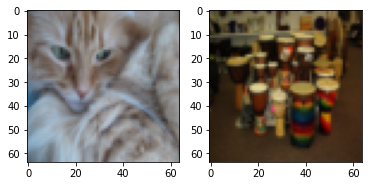

In [167]:
#collapse-hide

f=plt.figure()
ax1=f.add_subplot(121)
ax2=f.add_subplot(122)

index=2
ax1.imshow(train_x[index])
index=5
ax2.imshow(train_x[index])

plt.show()

Now we flatten and normalize the pictures for the neural network

In [168]:
train_x_norm=train_x.reshape(train_x.shape[0],-1).T /255.
test_x_norm=test_x.reshape(test_x.shape[0],-1).T /255.

print('train_x_norm_shape: {}, test_x_norm_shape: {}'.format(train_x_norm.shape,test_x_norm.shape))

train_x_norm_shape: (12288, 209), test_x_norm_shape: (12288, 50)


## Neural network training
When training a neural network the iteration count should be chosen. Iteration count determines how many times the neural network is going to evaluate itself and update its parameters.

In [169]:
np.random.seed(1)

def NeuralNetworkTrain(X, y, layer_dims, learning_rate, num_iterations, activation_names, cost_name):
    costs = []
    parameters = initialize_neural_network(layer_dims)
    layer_count=len(parameters)//2
    
    for i in range(0, num_iterations):
        forward_prop_cache = forward_prop(X, parameters, activation_names)

        y_pred = forward_prop_cache['a'+str(layer_count)] 
        cost = compute_cost(y_pred, y)
        backward_prop_cache = backward_prop(y_pred, y, cost_name, parameters, forward_prop_cache,\
                                            activation_names)
        parameters = update_parameters(parameters, backward_prop_cache, learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
            print('Iteration:{}, Cost={}'.format(i, cost))
            

    plt.plot(np.squeeze(costs))
    plt.show()

    return parameters



Now lets choose our hyperparmeters and train our network!

Iteration:0, Cost=0.7717493284237686
Iteration:100, Cost=0.6720534400822913
Iteration:200, Cost=0.6482632048575212
Iteration:300, Cost=0.6115068816101354
Iteration:400, Cost=0.5670473268366111
Iteration:500, Cost=0.54013766345478
Iteration:600, Cost=0.5279299569455268
Iteration:700, Cost=0.46547737717668525
Iteration:800, Cost=0.36912585249592816
Iteration:900, Cost=0.39174697434805333
Iteration:1000, Cost=0.3151869888600618
Iteration:1100, Cost=0.27269984417893894
Iteration:1200, Cost=0.23741853400268134
Iteration:1300, Cost=0.1996012053220864
Iteration:1400, Cost=0.1892630038846331
Iteration:1500, Cost=0.1611885466582775
Iteration:1600, Cost=0.1482138966236331
Iteration:1700, Cost=0.13777487812972944
Iteration:1800, Cost=0.12974017549190114
Iteration:1900, Cost=0.12122535068005202
Iteration:2000, Cost=0.11382060668633705
Iteration:2100, Cost=0.1078392852625413
Iteration:2200, Cost=0.10285466069352676
Iteration:2300, Cost=0.10089745445261789
Iteration:2400, Cost=0.09287821526472394
It

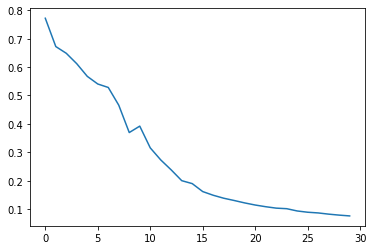

In [170]:
activation_names=['relu','relu','relu','sigmoid']
layer_dims=[12288,20,7,5,1]
learning_rate=0.0075
num_iterations=3000
cost_name='entropy'

parameters=NeuralNetworkTrain(train_x_norm,
                              train_y,
                              layer_dims,
                              learning_rate,
                              num_iterations,
                              activation_names,
                              cost_name)

## Result evaluation
The neural network is than evaluated on the training and test set by measuring accuracy, recall, precision and the F1 score

In [171]:
def print_results(X,y,parameters,activation_names,threshold=0.5):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    TP,TN,FP,FN=0,0,0,0

    forward_prop_cache = forward_prop(X, parameters, activation_names)
    y_pred=forward_prop_cache['a'+str(n)]


    for i in range(0, y_pred.shape[1]):
        if y_pred[0,i] > threshold:
            p[0,i] = 1
            if(y[0,i]==1):
                TP=TP+1
            else:
                FP=FP+1
                
        else:
            p[0,i] = 0
            if(y[0,i]==0):
                TN=TN+1
            else:
                FN=FN+1
              
    print('question is: is it a cat?')
    print()
    print('                ACTUALLY TRUE  ACTUALLY FALSE')
    print('PREDICTED TRUE     TP: {}         FP: {}'.format(TP,FP))
    print('PREDICTED FALSE    FN: {}         TN: {}'.format(FN,TN))
    print()
    print('accuracy: {}'.format((TP+TN)/(TP+TN+FP+FN)))
    print('precision: {}'.format(TP/(TP+TN)))
    print('recall: {}'.format(TP/(TP+FN)))
    print('f1: {}'.format((TP / ( (TP+( (FN+FP) / 2) )))))
    print()
    

In [172]:
print('-----TRAINING SET RESULTS-----')
print_results(train_x_norm,train_y,parameters, activation_names=['relu','relu','relu','sigmoid'])

print('-----TEST SET RESULTS-----')
print_results(test_x_norm,test_y,parameters, activation_names=['relu','relu','relu','sigmoid'])


-----TRAINING SET RESULTS-----
question is: is it a cat?

                ACTUALLY TRUE  ACTUALLY FALSE
PREDICTED TRUE     TP: 70         FP: 0
PREDICTED FALSE    FN: 2         TN: 137

accuracy: 0.9904306220095693
precision: 0.33816425120772947
recall: 0.9722222222222222
f1: 0.9859154929577465

-----TEST SET RESULTS-----
question is: is it a cat?

                ACTUALLY TRUE  ACTUALLY FALSE
PREDICTED TRUE     TP: 31         FP: 7
PREDICTED FALSE    FN: 2         TN: 10

accuracy: 0.82
precision: 0.7560975609756098
recall: 0.9393939393939394
f1: 0.8732394366197183



Lets predict the class of a random picture and show the result: 

In [173]:
def predict(x,parameters,activation_names,threshold=0.5):
    n = len(parameters) // 2
    forward_prop_cache = forward_prop(x, parameters, activation_names)
    y_pred=forward_prop_cache['a'+str(n)]
    print(y_pred)



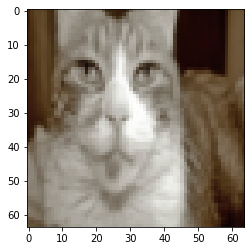

In [179]:
#collapse-hide 
index=np.random.choice(range(50))
img=test_x[index,:]
plt.imshow(img)

In [180]:
#collapse-hide

img_flatten=test_x_norm[:,index]
img_flatten=np.expand_dims(img_flatten, axis=1)

print('Predicted percentage of it being a cat:')
predict(img_flatten,parameters,activation_names)

Predicted percentage of it being a cat:
[[0.9999584]]


For additional material consider:

{{ '[Machine Learning Course by Stanford](https://www.coursera.org/learn/machine-learning)' | fndetail: 1 }}
{{ '[Deriving and implementing backpropagation](https://medium.com/binaryandmore/beginners-guide-to-deriving-and-implementing-backpropagation-e3c1a5a1e536)' | fndetail: 2 }}